In [ ]:
import pandas as pd

df = pd.read_csv('../../data/csvs/good_smiles.csv')

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen
import pandas as pd
from drugex.training.scorers.smiles import SmilesChecker
import pandas as pd
# Создаем калькулятор с нужным дескриптором
from mordred import Calculator, descriptors

calc = Calculator(descriptors, ignore_3D=True)

allowed_atoms = {'C', 'H', 'O', 'N', 'P', 'S'}

# SMARTS-шаблоны для фенола и аминов
phenol_pattern = Chem.MolFromSmarts('c1ccc(cc1)O')  # Фенольная группа
amine_pattern = Chem.MolFromSmarts('[NX3;H2,H1;!$(NC=O)]')  # Алифатические амины (но не амиды)

def is_valid_molecule(smiles):
    """
    Проверяет молекулу на соответствие критериям:
    - Нейтральность, отсутствие радикалов
    - Масса <= 1000
    - Только разрешённые атомы (C, H, O, N, P, S)
    - logP > 1
    - Наличие фенольной ИЛИ аминной группы
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False

    # 1. Проверка нейтральности и отсутствия радикалов
    if Chem.GetFormalCharge(mol) != 0:
        return False
    if any(atom.GetNumRadicalElectrons() != 0 for atom in mol.GetAtoms()):
        return False

    # 2. Молекулярная масса ≤ 1000
    if Descriptors.MolWt(mol) > 1000:
        return False

    # 3. Только разрешённые атомы
    atoms = {atom.GetSymbol() for atom in mol.GetAtoms()}
    if not atoms.issubset(allowed_atoms):
        return False

    # 4. logP > 1 (растворимость в гексане)
    if Crippen.MolLogP(mol) <= 1:
        return False

    if '+' in smiles:
        return False
    # 5. Наличие фенольной ИЛИ аминной группы
    has_phenol = mol.HasSubstructMatch(phenol_pattern)
    has_amine = mol.HasSubstructMatch(amine_pattern)
    if not (has_phenol or has_amine):
        return False

    if SmilesChecker.checkSmiles([smiles])['Valid'].to_list()[0] != 1.0:
        return False
    
    return True


# Функция для расчета AATSC0d
def compute_aatsc0d(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        result = calc(mol)
        return result['AATSC0d']
    except:
        return None

# Пример использования с DataFrame
# df = pd.read_csv("your_data.csv")  # Ваш DataFrame с колонкой 'SMILES'
df_filtered = df[df['SMILES'].apply(is_valid_molecule)].copy()

# Добавляем информацию о наличии фенольных/аминных групп
df_filtered['HasPhenol'] = df_filtered['SMILES'].apply(
    lambda smi: Chem.MolFromSmiles(smi).HasSubstructMatch(phenol_pattern))
df_filtered['HasAmine'] = df_filtered['SMILES'].apply(
    lambda smi: Chem.MolFromSmiles(smi).HasSubstructMatch(amine_pattern))

df_filtered['AATSC0d'] = df_filtered['SMILES'].apply(compute_aatsc0d)

print(f"Прошло фильтрацию: {len(df_filtered)} молекул из {len(df)}")
print("Распределение:")
print(f"- С фенольной группой: {df_filtered['HasPhenol'].sum()}")
print(f"- С аминной группой: {df_filtered['HasAmine'].sum()}")
print(f"- С обоими группами: {((df_filtered['HasPhenol']) & (df_filtered['HasAmine'])).sum()}")

In [ ]:
from drugex.training.scorers.properties import Property, Uniqueness, AtomCounter
from drugex.training.scorers.modifiers import ClippedScore
from drugex.training.environment import DrugExEnvironment
from drugex.training.rewards import WeightedSum
from drugex.training.scorers.qsprpred import QSPRPredScorer
from drugex.training.scorers.properties import Uniqueness


from rdkit import Chem


# 🔬 1. Модель для предсказания времени индукционного окисления (например, RandomForestRegressor)
scorer_tio = QSPRPredScorer(
    model = SklearnModel(
        name="A2AR_ForestRegressor_hack_data_extended_with_submits",
        base_dir='data/models/qsar/',
    )
)

scorer_tio.setModifier(ClippedScore(lower_x=200, upper_x=600))  # время в минутах
scorers = [scorer_tio]
uniq_scorer = Uniqueness(modifier=ClippedScore(lower_x=0.0, upper_x=0.5))
# scorers.append(uniq_scorer)
oxygen_scorer = AtomCounter('O', modifier=ClippedScore(lower_x=17, upper_x=40))
# scorers.append(oxygen_scorer)

sascore = Property("SA", modifier=ClippedScore(lower_x=5, upper_x=3))
scorers.append(sascore)
thresholds.append(4)

qed = Property("QED", modifier=ClippedScore(lower_x=0.4, upper_x=1.0))
scorers.append(qed)
thresholds.append(0.8)


logp = Property("logP", modifier=ClippedScore(lower_x=1.0, upper_x=6.0))
scorers.append(logp)
thresholds.append(3)

mw = Property("MW", modifier=ClippedScore(lower_x=100, upper_x=950))
scorers.append(mw)
thresholds.append(500)

environment = DrugExEnvironment(
    scorers=scorers,
    reward_scheme=WeightedSum()  # можно заменить на ParetoCrowdingDistance, если нужно
)


In [ ]:
reinforced = GraphTransformer(voc_trg=VocGraph(), use_gpus=GPUS)
reinforced.loadStatesFromFile('../../models/finetuned_graph_with_o/scaffolds.pkg')
denovo_new = reinforced.generate(input_frags=df.SMILES.to_list(), num_samples=400, evaluator=environment)

Initialized empty dataset. The data set file does not exist (yet): /tmp/tmphwgocpd9. You can add data by calling this instance with the appropriate parameters.


Creating fragment-molecule pairs (batch processing):   0%|          | 0/1 [00:00<?, ?it/s]

Encoding fragment-molecule pairs. (batch processing):   0%|          | 0/1 [00:00<?, ?it/s]

The following exception occured while encoding fragment COc1cc(C2Oc3cc([C@H]4Oc5cc(O)cc(O)c5C(=O)[C@@H]4O)ccc3OC2COC(=O)c2ccc3c(c2)OCO3)ccc1O for molecule CCCOc1cc(C2Oc3cc([C@H]4Oc5cc(O)cc(O)c5C(=O)[C@@H]4O)ccc3OC2COC(=O)c2ccc3c(c2)OCO3)ccc1O: 
Failed to convert item None to the new representation in <drugex.data.fragments.FragmentPairsEncodedSupplier object at 0x7f55966578b0>
	 Cause: FragmentEncodingException('Failed to encode fragment COc1cc(C2Oc3cc([C@H]4Oc5cc(O)cc(O)c5C(=O)[C@@H]4O)ccc3OC2COC(=O)c2ccc3c(c2)OCO3)ccc1O from molecule: CCCOc1cc(C2Oc3cc([C@H]4Oc5cc(O)cc(O)c5C(=O)[C@@H]4O)ccc3OC2COC(=O)c2ccc3c(c2)OCO3)ccc1O')
The following exception occured while encoding fragment COc1cc(C2Oc3cc([C@H]4Oc5cc(OC(=O)c6ccc7c(c6)OC(C)(C)O7)cc(O)c5C(=O)[C@@H]4O)ccc3OC2CO)ccc1O for molecule CCCOc1cc(C2Oc3cc([C@H]4Oc5cc(OC(=O)c6ccc7c(c6)OC(C)(C)O7)cc(O)c5C(=O)[C@@H]4O)ccc3OC2CO)ccc1O: 
Failed to convert item None to the new representation in <drugex.data.fragments.FragmentPairsEncodedSupplier o

Generating molecules:   0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
denovo_filtered_new = denovo_new[denovo_new['SMILES'].apply(is_valid_molecule)].drop_duplicates(subset='SMILES').copy()

In [106]:
denovo_filtered_new['O_count'] = denovo_filtered_new['SMILES'].str.count('O')

In [108]:
denovo_filtered_new.sort_values(by='O_count')[-10:]

,SMILES,preds,O_count
55,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC1CCCC(OC2CCO...,66.600704,7
49,CC(=O)COc1ccc(C=CC(O)=CC(C)(C)C(O)CCC2(C)CCC3C...,62.703115,8
66,CCc1cc2c(cc1-c1ccc3c4c(ccc3c1)C1C3=C(CNC1C(=O)...,120.111764,8
70,CCc1ccc2c(c1-c1ccc3cc4c(ccc5c6c(ccc54)OC4(CCC(...,80.295329,8
78,O=C1CC(=O)C2CNCc3cc(C4CCCCC4)c(-c4ccc5c6c(ccc5...,87.602803,8
43,CCCCCCCCc1ccc(-c2ccc3c(c2)C2(CCCC(c4ccc5c(c4)c...,125.978891,8
12,CCCCCCCCOc1cc(O)c2c(=O)cc(-c3ccc(Oc4ccc(C(=O)N...,77.708562,9
63,CCCCc1ccc2cc3c(ccc4c5ccc6c(oc5c5c(c34)OCC(O)C5...,95.922524,14
18,CC(=O)C1OC1c1ccc(C(O)C(C)(C)C)c2c1C(OC1CCCC(CO...,92.191978,14
80,CCCCCCCc1cccc(-c2cccc(C3=CC(=O)c4c5c(c6c(c4C3=...,117.980825,14


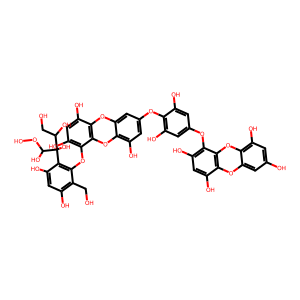

In [90]:
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

mol = Chem.MolFromSmiles(denovo_filtered_new.sort_values(by='O_count').SMILES.tolist()[-1])
drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:', '')
SVG(svg)


In [ ]:
submission_list = denovo_filtered_new.sort_values(by='O_count')['SMILES'].to_list()[-10:]
pd.DataFrame({'SMILES': submission_list}).to_csv('submission.csv', index=False, encoding='utf-8')

or without applying the modifiers to better evaluate the predicted properties.